In [46]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import gillespie as gp
import statistics as st
import seaborn as sns
from scipy.signal import find_peaks


# Implement Gillespie's algorithm

Gillespie's Algorithm (Stochastic SIR Model)

In [37]:
beta = 1
gamma = 1/30
mu = 1/60
N = 1000
X0 = 990
Y0 = 1
Z0 = 0

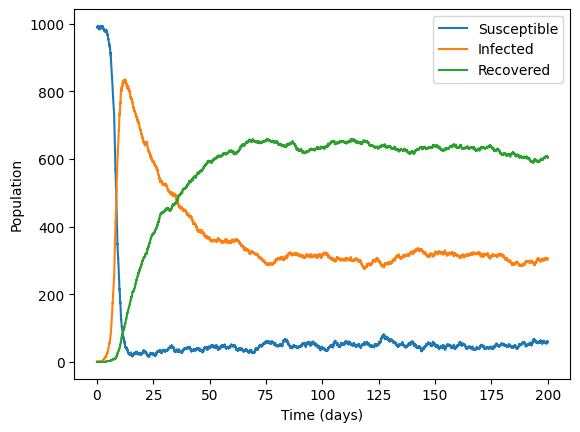

In [38]:
def gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    X = [X0]
    Y = [Y0]
    Z = [Z0]
    t = [0]

    R0_stoch = beta / (mu + gamma)

    # Gillespie algorithm loop
    while t[-1] < tend:
        current_X = X[-1]
        current_Y = Y[-1]
        current_Z = Z[-1]
        
        # If there are no susceptible and infected, break out of the loop (epidemic is over)
        if current_Y == 0 and current_X == 0:
            break

        # Rates for all possible events
        birth_rate = mu * N
        infection_rate = beta * current_X * current_Y / N
        recovery_rate = gamma * current_Y
        death_susc_rate = mu * current_X
        death_inf_rate = mu * current_Y
        death_recov_rate = mu * current_Z

        rates = [birth_rate, infection_rate, recovery_rate,
                 death_susc_rate, death_inf_rate, death_recov_rate]
        rate_sum = sum(rates)

        # If rate_sum is zero, no more events are possible
        if rate_sum <= 0:
            break  # End the simulation

        # Time until next event (exponentially distributed)
        tau = np.random.exponential(scale=1/rate_sum)
        t.append(t[-1] + tau)

        rand = random.uniform(0, rate_sum)
        cum_rate = 0

        # Determine which event happens next
        if rand < (cum_rate := cum_rate + birth_rate): # Birth
            current_X += 1
        
        elif rand < (cum_rate := cum_rate + infection_rate) and current_X > 0: # Infection
            current_X -= 1
            current_Y += 1
        
        elif rand < (cum_rate := cum_rate + recovery_rate) and current_Y > 0: # Recovery
            current_Y -= 1
            current_Z += 1

        elif rand < (cum_rate := cum_rate + death_susc_rate):  # Death of susceptible
            current_X -= 1

        elif rand < (cum_rate := cum_rate + death_inf_rate):  # Death of infected
            current_Y -= 1

        elif rand < (cum_rate := cum_rate + death_recov_rate): # Death of recovered
                current_Z -= 1

        X.append(current_X)
        Y.append(current_Y)
        Z.append(current_Z)

    return X, Y, Z, t, R0_stoch

tend = 200 # simulation time (200 days)
seed = 42

Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

# Plot the results
plt.plot(t, Xs, label="Susceptible")
plt.plot(t, Ys, label="Infected")
plt.plot(t, Zs, label="Recovered")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.show()

Deterministic SIR Model

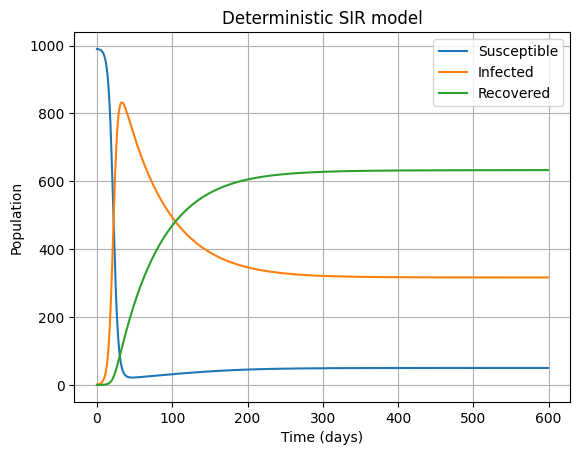

In [39]:
start_t = 0
end_t = 200
points_t = 600
init_val = [X0, Y0, Z0]

# Defining the deterministic ODEs
def SIR(val, t, beta, gamma, mu, N): 
    X, Y, Z = val

    dXdt = mu * N - beta * X * Y / N - mu * X 
    dYdt = beta * X * Y / N - gamma * Y - mu * Y 
    dZdt = gamma * Y - mu * Z 
    
    return np.array([dXdt, dYdt, dZdt])

# Solving the deterministic SIR model
def deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t):

    R0_det = beta / (mu + gamma)

    time = np.linspace(start_t, end_t, points_t)
    init_val = [X0, Y0, Z0]
    solution = odeint(SIR, init_val, time, args=(beta, gamma, mu, N))
    Xd, Yd, Zd = solution.T

    return Xd, Yd, Zd, time, R0_det

Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

plt.plot(Xd, label="Susceptible")
plt.plot(Yd, label="Infected")
plt.plot(Zd, label = "Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("Deterministic SIR model")
plt.legend()
plt.grid()
plt.show()


Plotting Deterministic and Stochastic SIR

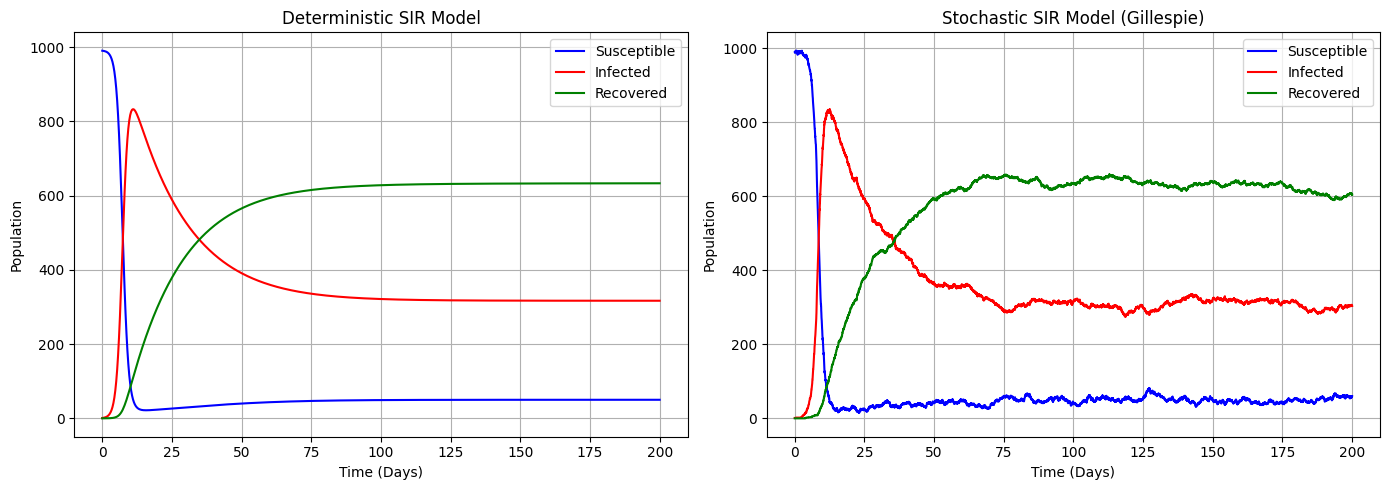

In [40]:
# Solving the deterministic model
Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)
# Solving the stochastic model using Gillespie algorithm
Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(time, Xd, label="Susceptible", color='blue')
ax1.plot(time, Yd, label="Infected", color='red')
ax1.plot(time, Zd, label="Recovered", color='green')
ax1.set_title("Deterministic SIR Model")
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Population")
ax1.legend(loc="best")
ax1.grid(True)

ax2.plot(t, Xs, label="Susceptible", color='blue')
ax2.plot(t, Ys, label="Infected", color='red')
ax2.plot(t, Zs, label="Recovered", color='green')
ax2.set_title("Stochastic SIR Model (Gillespie)")
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Population")
ax2.legend(loc="best")
ax2.grid(True)

plt.tight_layout()
plt.show()

Function to run multiple simulations of stochastic SIR (and return mean and variance of X, Y, Z)

Number of simulations: 50
Mean of Susceptibles: 142.87121439027328
Variance of Susceptibles: 75564.21680862013
Mean of Infected: 280.53527589860664
Variance of Infected: 9042.127827824197


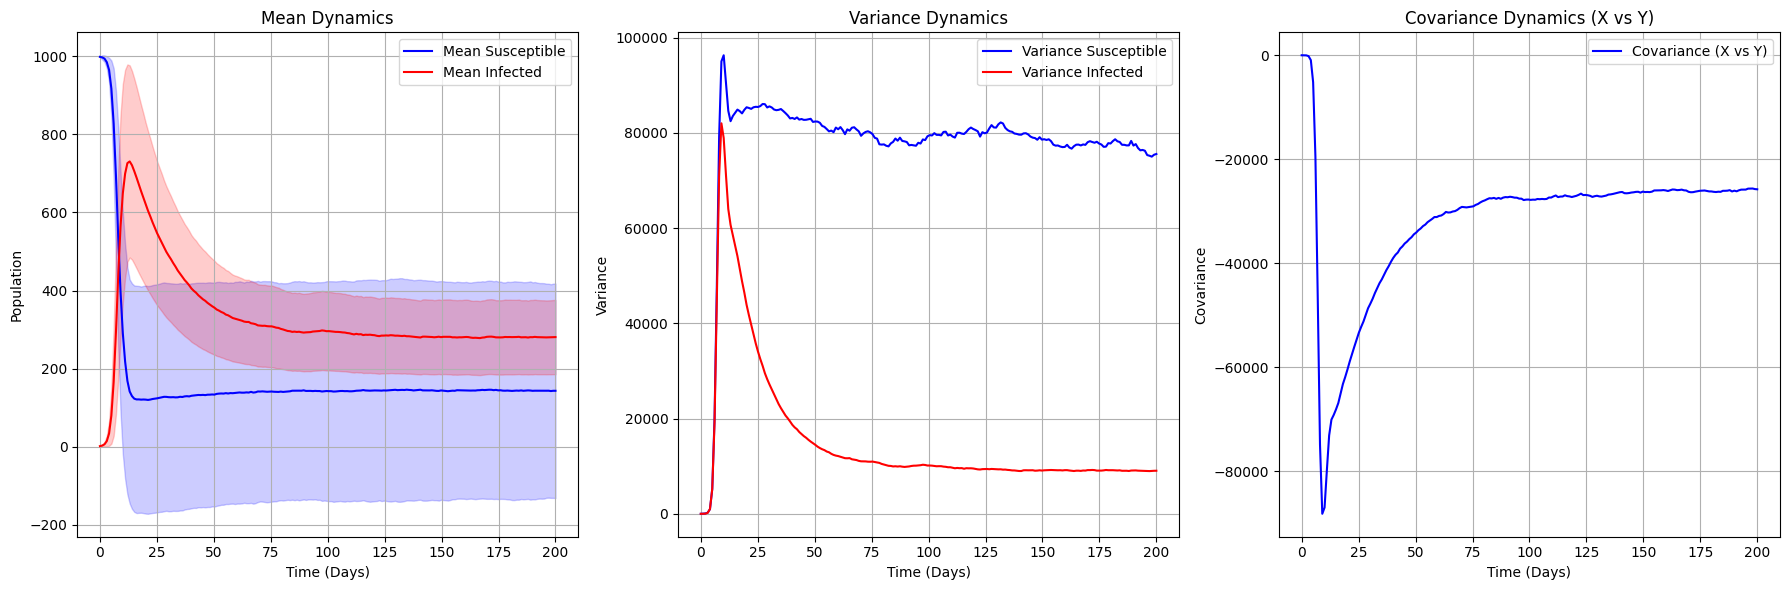

In [41]:
def run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed):
    # Accumulating Xs, Ys, Zs across simulations
    all_Xs = [] 
    all_Ys = []  
    all_Zs = []
    cov_array = np.zeros(tend)

    time_p = np.linspace(0, tend, 200) # 200 time points

    for i in range(sims):
        # Run Gillespie simulation for current iteration
        Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend)

        # Interpolate to have consistent time points
        X_interp = np.interp(time_p, t, Xs)
        Y_interp = np.interp(time_p, t, Ys)
        Z_interp = np.interp(time_p, t, Zs)

        all_Xs.append(X_interp)
        all_Ys.append(Y_interp)
        all_Zs.append(Z_interp)

    all_Xs = np.array(all_Xs)
    all_Ys = np.array(all_Ys)
    all_Zs = np.array(all_Zs)

    # Average population size of each compartment at each time point
    mean_Xs = np.mean(all_Xs, axis = 0)
    mean_Ys = np.mean(all_Ys, axis = 0)
    mean_Zs = np.mean(all_Zs, axis = 0)

    # Variability of population sizes across simulations
    var_Xs = np.var(all_Xs, axis = 0)
    var_Ys = np.var(all_Ys, axis = 0)
    var_Zs = np.var(all_Zs, axis = 0)

    return time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys

# Computing covariance between S and I
def covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend):
    cov_Xs_Ys = np.zeros(tend)
    for t in range(tend):
        cov_Xs_Ys[t] = np.mean((all_Xs[:, t] - mean_Xs[t]) * (all_Ys[:, t] - mean_Ys[t]))
    return cov_Xs_Ys

sims = 50
X0 = 999
Y0 = 1
Z0 = 0
beta = 1
gamma = 1/30
mu = 1/60
N = X0 + Y0 + Z0
tend = 200

# Run the stochastic simulations
time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)
cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend)

print(f"Number of simulations: {sims}")
print(f"Mean of Susceptibles: {mean_Xs[-1]}")
print(f"Variance of Susceptibles: {var_Xs[-1]}")
print(f"Mean of Infected: {mean_Ys[-1]}")
print(f"Variance of Infected: {var_Ys[-1]}")

# Plotting the mean, variance and covariance (X vs Y)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

std_Xs = np.std(all_Xs, axis=0)
std_Ys = np.std(all_Ys, axis=0)

axes[0].plot(time_p, mean_Xs, label='Mean Susceptible', color='blue')
axes[0].plot(time_p, mean_Ys, label='Mean Infected', color='red')
axes[0].fill_between(time_p, mean_Xs - std_Xs, mean_Xs + std_Xs, color='blue', alpha=0.2)
axes[0].fill_between(time_p, mean_Ys - std_Ys, mean_Ys + std_Ys, color='red', alpha=0.2)
axes[0].set_title("Mean Dynamics")
axes[0].set_xlabel("Time (Days)")
axes[0].set_ylabel("Population")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(time_p, var_Xs, label='Variance Susceptible', color='blue')
axes[1].plot(time_p, var_Ys, label='Variance Infected', color='red')
axes[1].set_title("Variance Dynamics")
axes[1].set_xlabel("Time (Days)")
axes[1].set_ylabel("Variance")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(time_p, cov_Xs_Ys, label='Covariance (X vs Y)', color='blue')
axes[2].set_title("Covariance Dynamics (X vs Y)")
axes[2].set_xlabel("Time (Days)")
axes[2].set_ylabel("Covariance")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Investigate Simulation Variability and Negative Co-variance

In [42]:
# Fixed parameters
N = 1000
beta = 1
gamma = 1/3
mu = 1/60
sims = 5

Varying N

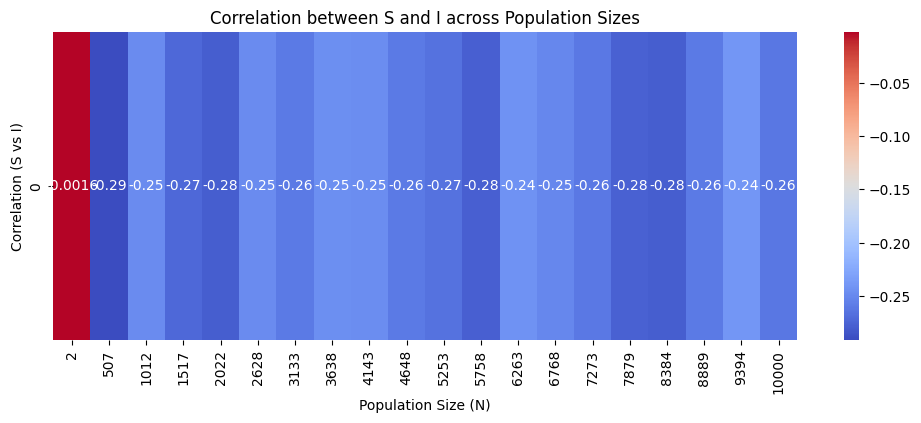

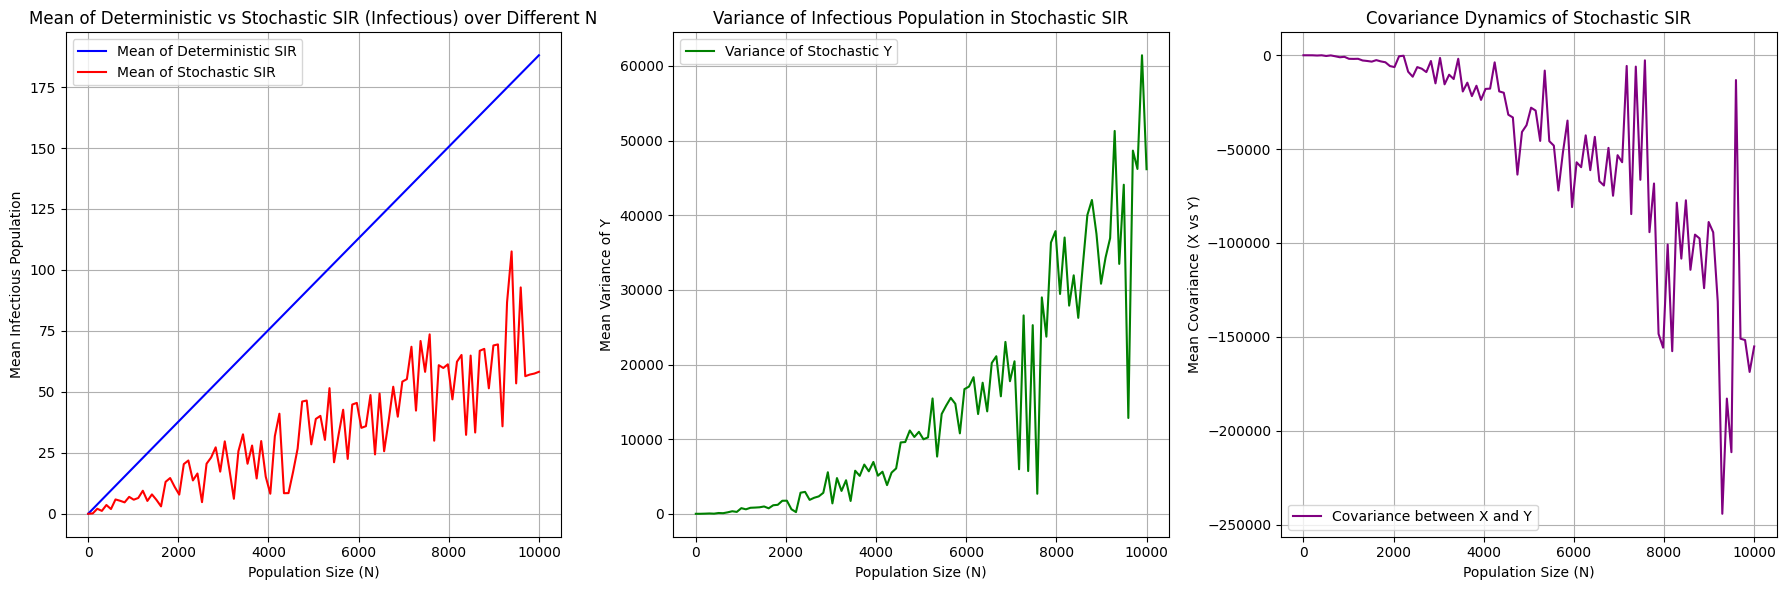

([np.float64(0.041014153094800464),
  np.float64(1.9437493906873642),
  np.float64(3.858812234044779),
  np.float64(5.771164115026165),
  np.float64(7.681774924632135),
  np.float64(9.5911012475867),
  np.float64(11.499409891541033),
  np.float64(13.40687640750633),
  np.float64(15.313624952664984),
  np.float64(17.21974789820679),
  np.float64(19.125317023548938),
  np.float64(21.030389009696336),
  np.float64(22.93501062623567),
  np.float64(24.83922026170106),
  np.float64(26.743050342584592),
  np.float64(28.64652861541949),
  np.float64(30.549679735787567),
  np.float64(32.452523775592304),
  np.float64(34.35507986574707),
  np.float64(36.25736443195206),
  np.float64(38.15939181409083),
  np.float64(40.061175334843966),
  np.float64(41.96272715754345),
  np.float64(43.86405759797173),
  np.float64(45.765176977100346),
  np.float64(47.666094394137616),
  np.float64(49.566817211502574),
  np.float64(51.46735410725823),
  np.float64(53.36771178239023),
  np.float64(55.26789697981052

In [43]:

def diff_params_N(N_diff, sims, beta, gamma, mu):
    
    mean_deter = []  # Means from the deterministic model
    mean_stoch = []  # Means from the stochastic model
    var_Y = []       # Variances of Y
    cov_XY = []      # Covariances between X and Y
    correlations = []  # Correlations between X and Y

    # Iterate through different population sizes
    for n in np.nditer(N_diff):
        X0 = int(n) - 1   # Initial susceptible population
        Y0 = 1            # Initial infected population
        Z0 = 0            # Initial recovered population
        
        # Run stochastic and deterministic simulations for the current population size
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, int(n), tend=200)
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, int(n), beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append final mean for deterministic and stochastic model
        mean_deter.append(np.mean(Yd))  
        mean_stoch.append(np.mean(mean_Ys))

        # Append final variance of stochastic model
        var_Y.append(np.mean(var_Ys)) 

        # Calculate and append final covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

        # Calculate the correlation between X and Y
        correlation_si = np.corrcoef(all_Xs.flatten(), all_Ys.flatten())[0, 1]  # Correlation coefficient between S and I
        correlations.append(correlation_si)
        
    # Reduce the number of population sizes shown in the heatmap
    selected_indices = np.linspace(0, len(N_diff) - 1, 20).astype(int)  # Select 20 population sizes to display
    N_diff_selected = N_diff[selected_indices]
    correlations_selected = np.array(correlations)[selected_indices]

    # Create a heatmap of the correlation between X and Y across population sizes
    plt.figure(figsize=(12, 4))
    sns.heatmap(np.array(correlations_selected).reshape(1, -1), annot=True, cmap='coolwarm', xticklabels=np.round(N_diff_selected).astype(int))
    plt.title("Correlation between S and I across Population Sizes")
    plt.xlabel("Population Size (N)")
    plt.ylabel("Correlation (S vs I)")
    plt.show()

    # Initialize the other plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(N_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(N_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different N")
    axes[0].set_xlabel("Population Size (N)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(N_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over N
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Population Size (N)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(N_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over N
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Population Size (N)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()


    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY , time_p, all_Ys

# Example usage
N_diff = np.linspace(2, 10000, 100)  # Different values of population
sims = 5  # Number of stochastic simulations
beta = 1.5
gamma = 0.5
mu = 0.01

diff_params_N(N_diff, sims, beta, gamma, mu)


Varying Y0 (initial number of infectious individuals)

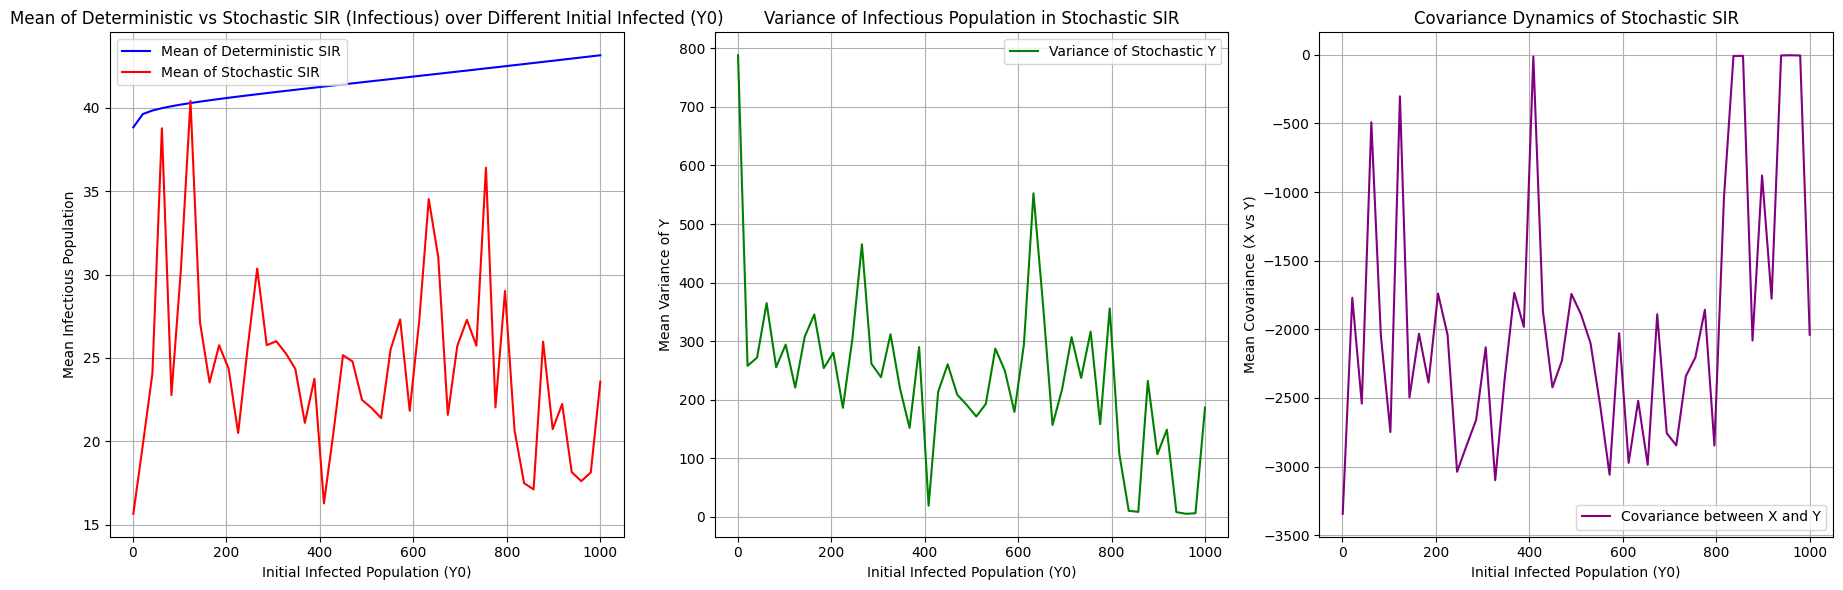

([np.float64(38.83661873281555),
  np.float64(39.63116133509062),
  np.float64(39.840531625276256),
  np.float64(39.98374281460865),
  np.float64(40.099487583414856),
  np.float64(40.20019951783365),
  np.float64(40.29147975169117),
  np.float64(40.376336718908085),
  np.float64(40.45657389841985),
  np.float64(40.5333588421937),
  np.float64(40.60749166046536),
  np.float64(40.67954370881446),
  np.float64(40.74993791897318),
  np.float64(40.818996249739946),
  np.float64(40.88696951836507),
  np.float64(40.95405608242545),
  np.float64(41.020416766687724),
  np.float64(41.086182738860025),
  np.float64(41.15146262887671),
  np.float64(41.21634738154697),
  np.float64(41.28091427369813),
  np.float64(41.34522805656681),
  np.float64(41.4093450207486),
  np.float64(41.473313915794854),
  np.float64(41.53717577321484),
  np.float64(41.60096757768716),
  np.float64(41.66472086207156),
  np.float64(41.72846377998962),
  np.float64(41.79222061046627),
  np.float64(41.85601351235696),
  np.

In [33]:
Y0_diff = np.linspace(1, 1000, 50)

def diff_params_Y0(N, Y0_diff, sims, beta, gamma, mu):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different initial infected populations Y0
    for y0 in Y0_diff:
        X0 = N - y0  # Initial susceptible population
        Y0 = y0      # Initial infected population
        Z0 = 0       # Initial recovered population
        
        # Run stochastic simulations for the current population size
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current population size
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(Y0_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(Y0_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Initial Infected (Y0)")
    axes[0].set_xlabel("Initial Infected Population (Y0)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(Y0_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over Y0
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Initial Infected Population (Y0)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(Y0_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over Y0
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Initial Infected Population (Y0)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

diff_params_Y0(N, Y0_diff, sims, beta, gamma, mu)


In [170]:
X0 = 999
Y0 = 1
Z0 = 0

Varying beta (transmission rate)

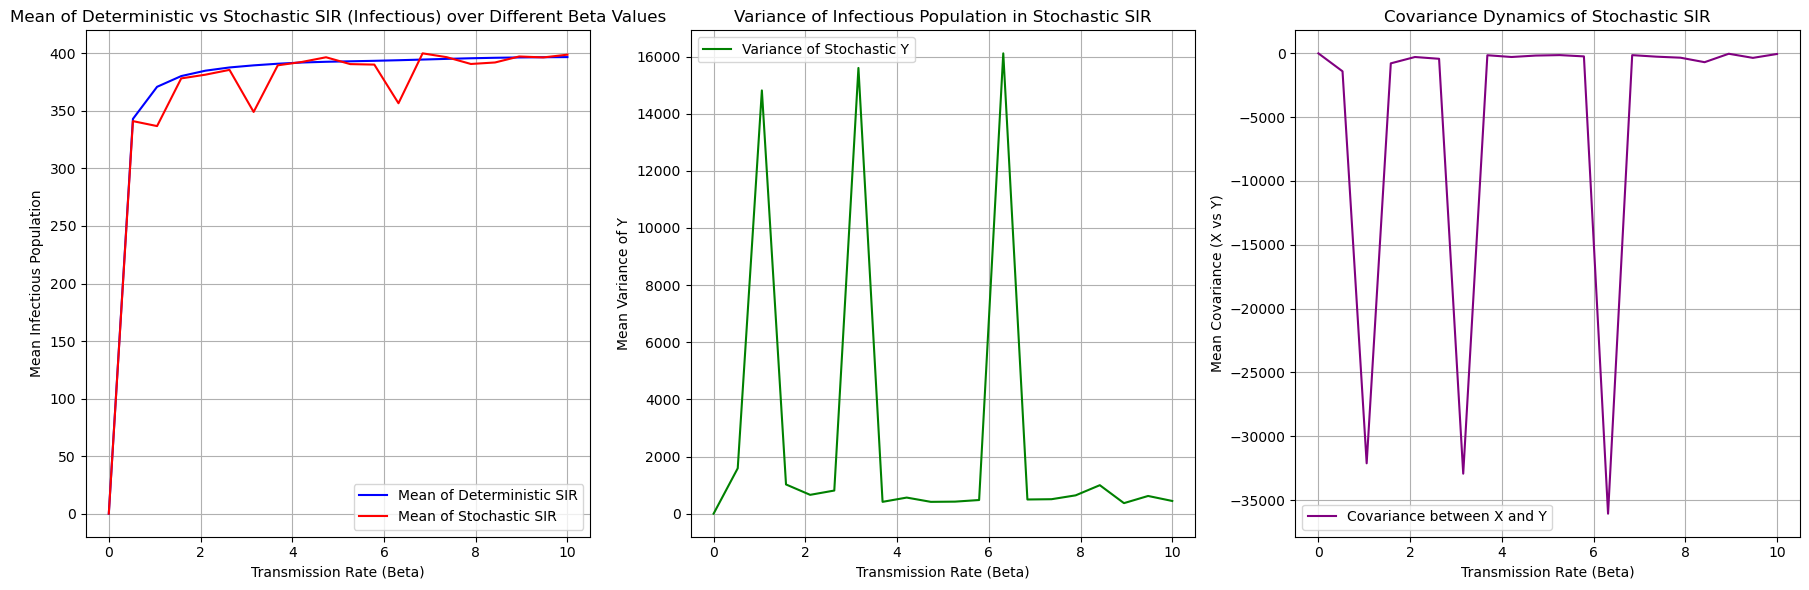

([0.10201653252049592,
  342.95730739875006,
  370.8143212275526,
  380.1361714081288,
  384.8017551744721,
  387.6156646619176,
  389.4410200650615,
  390.8614626701294,
  391.9171197727623,
  392.5466079052897,
  392.96790092476965,
  393.386260114045,
  393.89077233184304,
  394.4754215295905,
  395.07375857480673,
  395.60583247541445,
  396.02133437448583,
  396.3124344286154,
  396.4990318814838,
  396.60998435771194],
 [0.13850000000000004,
  341.0111846692308,
  336.70619030433284,
  378.1157006414036,
  381.33237588634125,
  385.5186123399003,
  348.9761941921864,
  389.4759399231971,
  392.40077099373275,
  396.46689713548255,
  390.5303768846103,
  390.09601553722104,
  356.5281380339738,
  399.8671488610988,
  396.5373558118519,
  390.63876986730446,
  391.94164727113747,
  397.15693149171085,
  396.3340237323737,
  398.73063264226136],
 [0.06665000000000003,
  1589.987493132422,
  14815.106803755843,
  1023.9888995815043,
  660.361234312919,
  810.7507387368797,
  15601.24

In [171]:
beta_diff = np.linspace(0, 10, 20)

def diff_params_beta(N, sims, beta_diff, gamma, mu, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different beta values
    for beta in beta_diff:
        
        # Run stochastic simulations for the current beta
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current beta
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(beta_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(beta_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Beta Values")
    axes[0].set_xlabel("Transmission Rate (Beta)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(beta_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over beta
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Transmission Rate (Beta)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(beta_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over beta
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Transmission Rate (Beta)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY, time_p, all_Ys

# Call the function with fixed parameters and varying beta
diff_params_beta(N, sims, beta_diff, gamma, mu, X0, Y0, Z0)

Varying gamma (rate of recovery)

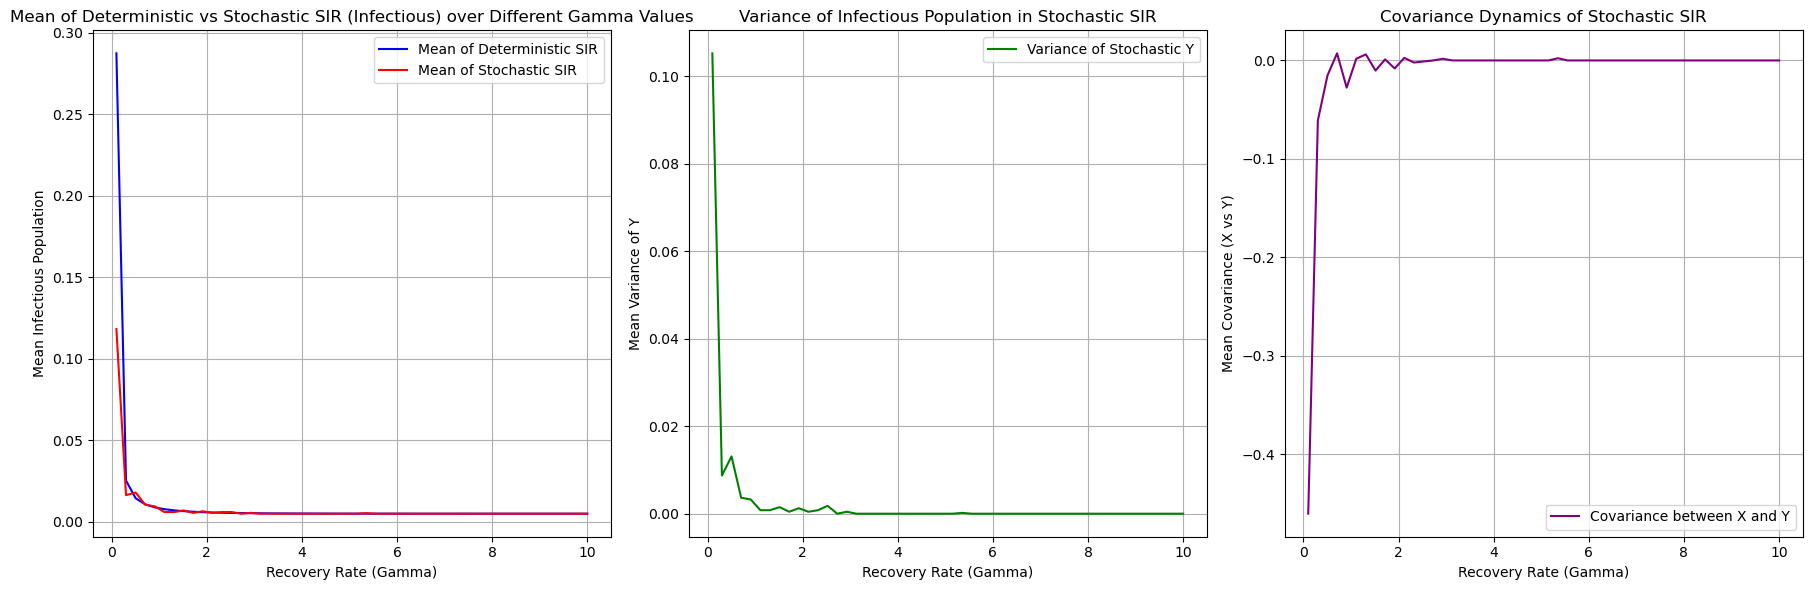

([0.28732280130494375,
  0.02532696797174353,
  0.014496860062526828,
  0.010746061493925051,
  0.008872340849531993,
  0.007766936769937647,
  0.00704999283730604,
  0.006556032720294407,
  0.006201378148660035,
  0.005939136292499107,
  0.0057409781337085875,
  0.005588776047769523,
  0.005470398673674226,
  0.005377429422175059,
  0.005303855408887289,
  0.005245277279172998,
  0.005198414759898304,
  0.005160780167310785,
  0.005130462857185386,
  0.005105979798912757,
  0.005086168656442191,
  0.005070111754364289,
  0.005057079925455614,
  0.00504649330490865,
  0.0050378845700343846,
  0.005030878938818009,
  0.005025176397132715,
  0.005020530759025754,
  0.005016745169523231,
  0.0050136594563454165,
  0.005011143777437827,
  0.005009092307041075,
  0.00500741887774993,
  0.005006053680054772,
  0.005004940433254269,
  0.005004031725831783,
  0.005003290303093584,
  0.0050026855082085705,
  0.005002191649620733,
  0.0050017890902433115,
  0.005001459862990405,
  0.005001191613

In [172]:
gamma_diff = np.linspace(0.1, 10, 50)


def diff_params_gamma(N, sims, beta, gamma_diff, mu, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different gamma values
    for gamma in gamma_diff:

        # Run stochastic simulations for the current gamma
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current gamma
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(gamma_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(gamma_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Gamma Values")
    axes[0].set_xlabel("Recovery Rate (Gamma)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(gamma_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over gamma
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Recovery Rate (Gamma)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(gamma_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over gamma
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Recovery Rate (Gamma)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY, time_p, all_Ys

# Call the function with fixed parameters and varying gamma
diff_params_gamma(N, sims, beta, gamma_diff, mu, X0, Y0, Z0)

Varying mu (birth rate)

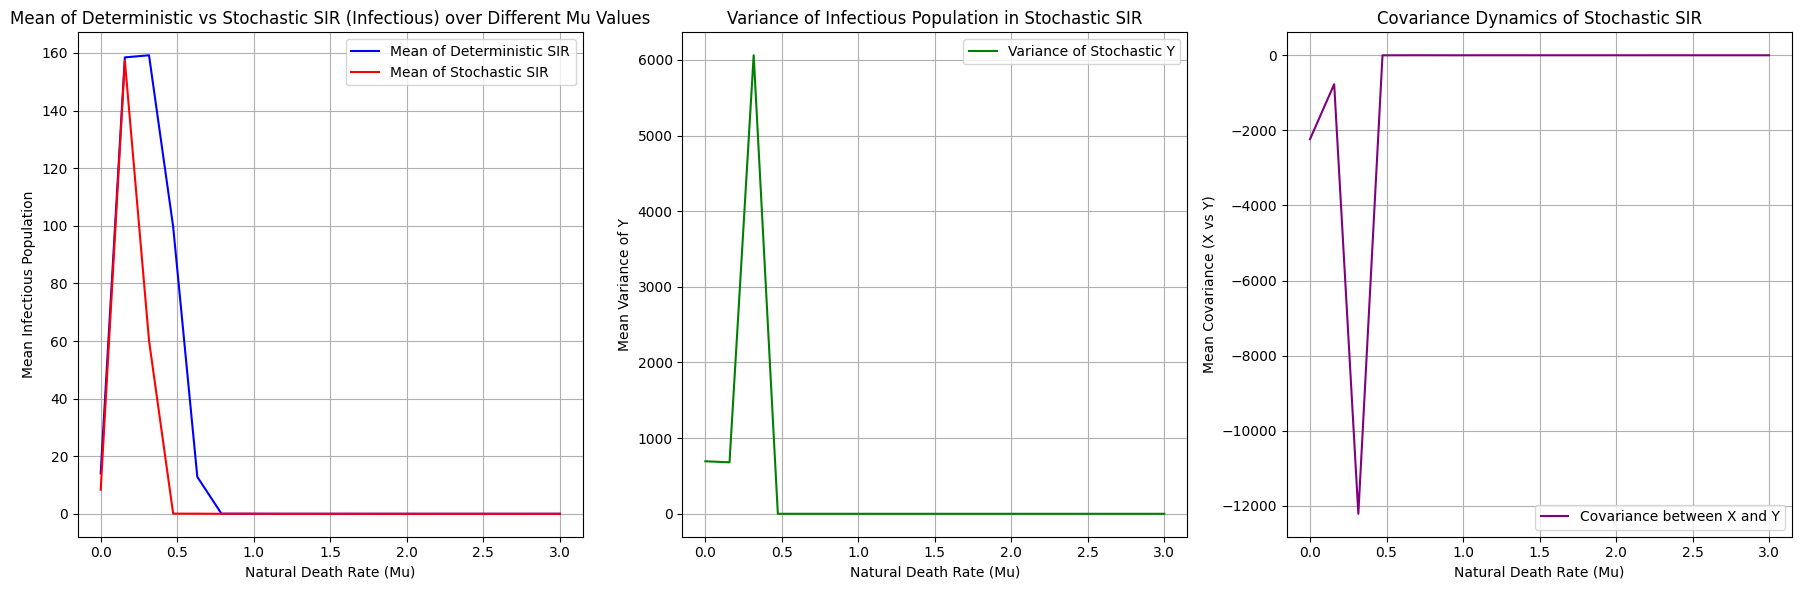

([np.float64(14.039965321719817),
  np.float64(158.47306764618298),
  np.float64(159.21363549893417),
  np.float64(99.67142228681723),
  np.float64(12.824966970983937),
  np.float64(0.042839003397861966),
  np.float64(0.02030123049435818),
  np.float64(0.014010796832400432),
  np.float64(0.011080920606148136),
  np.float64(0.009403054174886526),
  np.float64(0.008327149575733956),
  np.float64(0.007586458981495443),
  np.float64(0.007051279005250761),
  np.float64(0.006650934063187211),
  np.float64(0.006343612034081991),
  np.float64(0.006102985172529012),
  np.float64(0.005911644740942561),
  np.float64(0.005757617344575774),
  np.float64(0.0056323972956140245),
  np.float64(0.005529777870007503)],
 [np.float64(8.35296307431186),
  np.float64(157.34576124526677),
  np.float64(60.17980029939963),
  np.float64(0.064),
  np.float64(0.048),
  np.float64(0.006999999999999999),
  np.float64(0.042),
  np.float64(0.011000000000000001),
  np.float64(0.006),
  np.float64(0.005),
  np.float64(0

In [39]:
mu_diff = np.linspace(0, 3, 20)

def diff_params_mu(N, sims, beta, gamma, mu_diff, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different mu values
    for mu in mu_diff:
        # Run stochastic simulations for the current mu
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current mu
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(mu_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(mu_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Mu Values")
    axes[0].set_xlabel("Natural Death Rate (Mu)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(mu_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over mu
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Natural Death Rate (Mu)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(mu_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over mu
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Natural Death Rate (Mu)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

# Call the function with varying mu
diff_params_mu(N, sims, beta, gamma, mu_diff, X0, Y0, Z0)

# Stochastic Resonance and Increased Transient

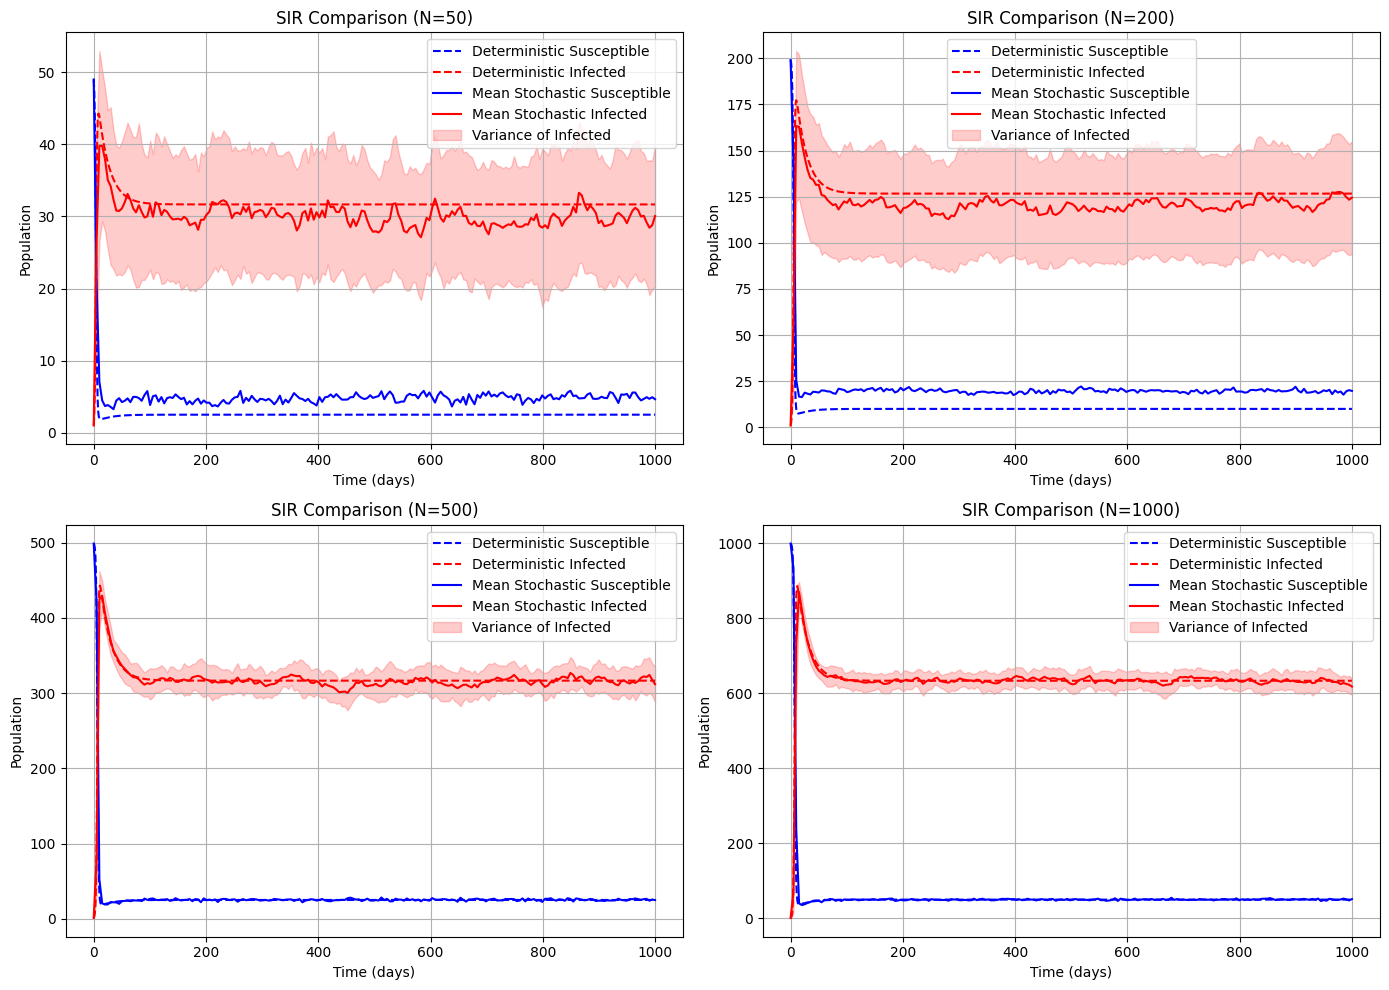

In [75]:
N = [50, 200, 500, 1000]
beta = 1
gamma = 1 / 60
mu = 1 / 30
start_t = 0
end_t = 1000
points_t = 1000
sims = 20
tend = 1000

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, n in enumerate(N):
    X0 = n - 1
    Y0 = 1
    Z0 = 0

    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, n, beta, gamma, mu, start_t, end_t, points_t)
    time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, n, tend)

    axs[i // 2, i % 2].plot(time, Xd, 'b--', label="Deterministic Susceptible")
    axs[i // 2, i % 2].plot(time, Yd, 'r--', label="Deterministic Infected")
    axs[i // 2, i % 2].plot(time_p, mean_Xs, 'b', label=f"Mean Stochastic Susceptible")
    axs[i // 2, i % 2].plot(time_p, mean_Ys, 'r', label=f"Mean Stochastic Infected")
    
    axs[i // 2, i % 2].fill_between(time_p, 
                                     mean_Ys - np.sqrt(var_Ys), 
                                     mean_Ys + np.sqrt(var_Ys), 
                                     color='red', alpha=0.2, label='Variance of Infected')
    
    axs[i // 2, i % 2].set_title(f"SIR Comparison (N={n})")
    axs[i // 2, i % 2].set_xlabel("Time (days)")
    axs[i // 2, i % 2].set_ylabel("Population")
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()


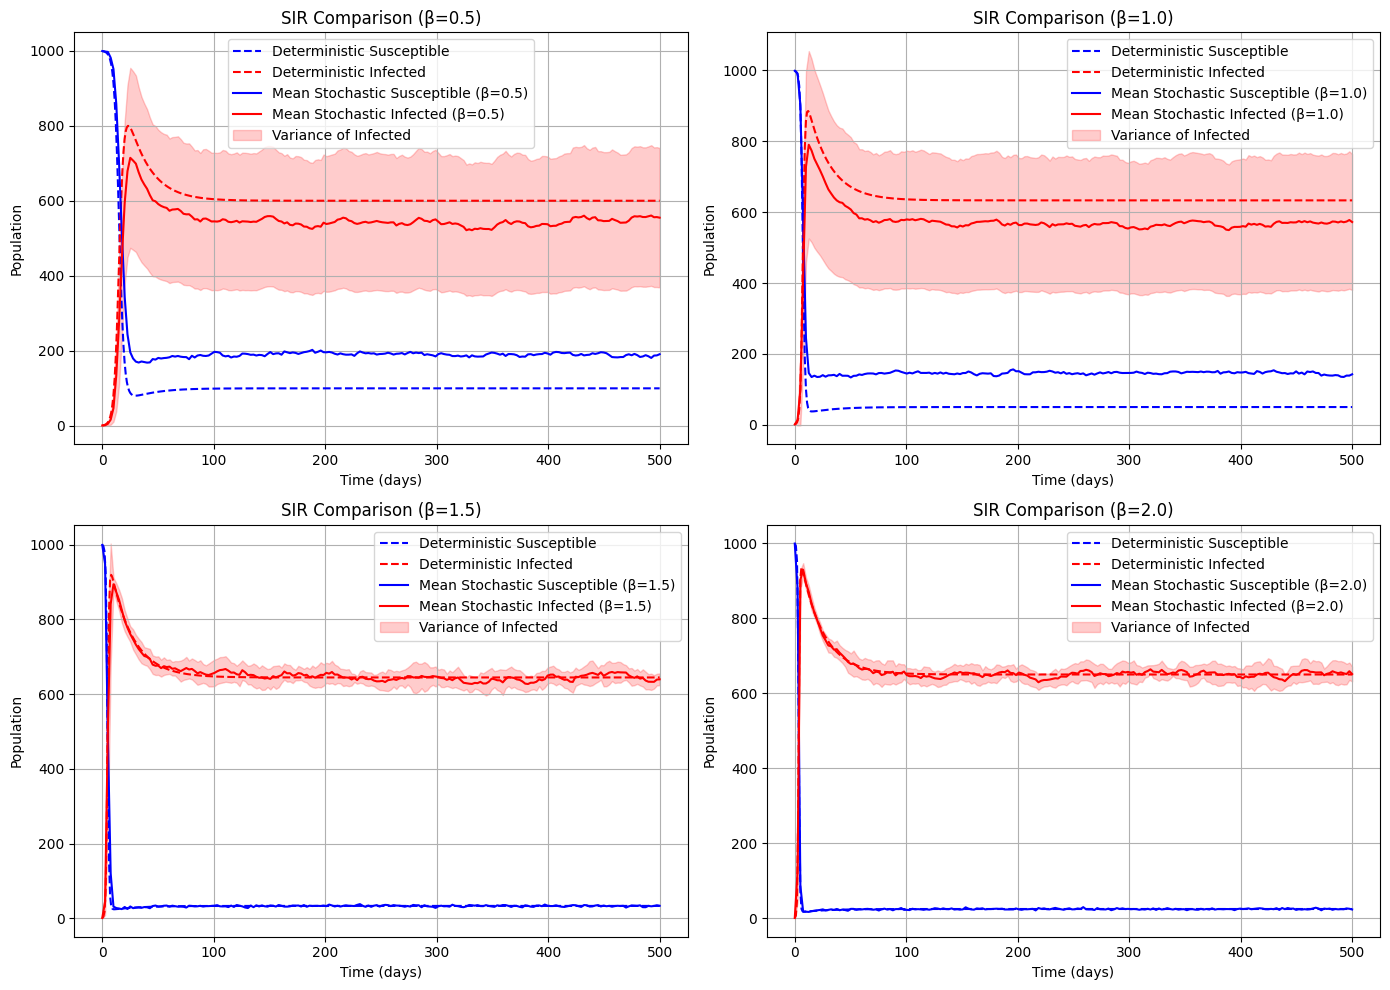

In [68]:
N = 1000  # Population size
beta_values = [0.5, 1.0, 1.5, 2.0]  # Different values for beta
gamma = 1 / 60
mu = 1 / 30
start_t = 0
end_t = 500
points_t = 500
sims = 10
tend = 500

# Prepare subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, beta in enumerate(beta_values):
    X0 = N - 1
    Y0 = 1
    Z0 = 0

    # Run deterministic solution
    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

    # Run stochastic simulation
    time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)

    # Top row: Mean plots with shaded variance for infected
    axs[i // 2, i % 2].plot(time, Xd, 'b--', label="Deterministic Susceptible")
    axs[i // 2, i % 2].plot(time, Yd, 'r--', label="Deterministic Infected")
    axs[i // 2, i % 2].plot(time_p, mean_Xs, 'b', label=f"Mean Stochastic Susceptible (β={beta})")
    axs[i // 2, i % 2].plot(time_p, mean_Ys, 'r', label=f"Mean Stochastic Infected (β={beta})")
    
    # Shaded region for variance of infected
    axs[i // 2, i % 2].fill_between(time_p, 
                                     mean_Ys - np.sqrt(var_Ys), 
                                     mean_Ys + np.sqrt(var_Ys), 
                                     color='red', alpha=0.2, label='Variance of Infected')
    
    axs[i // 2, i % 2].set_title(f"SIR Comparison (β={beta})")
    axs[i // 2, i % 2].set_xlabel("Time (days)")
    axs[i // 2, i % 2].set_ylabel("Population")
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].grid()

# Adjust layout
plt.tight_layout()
plt.show()



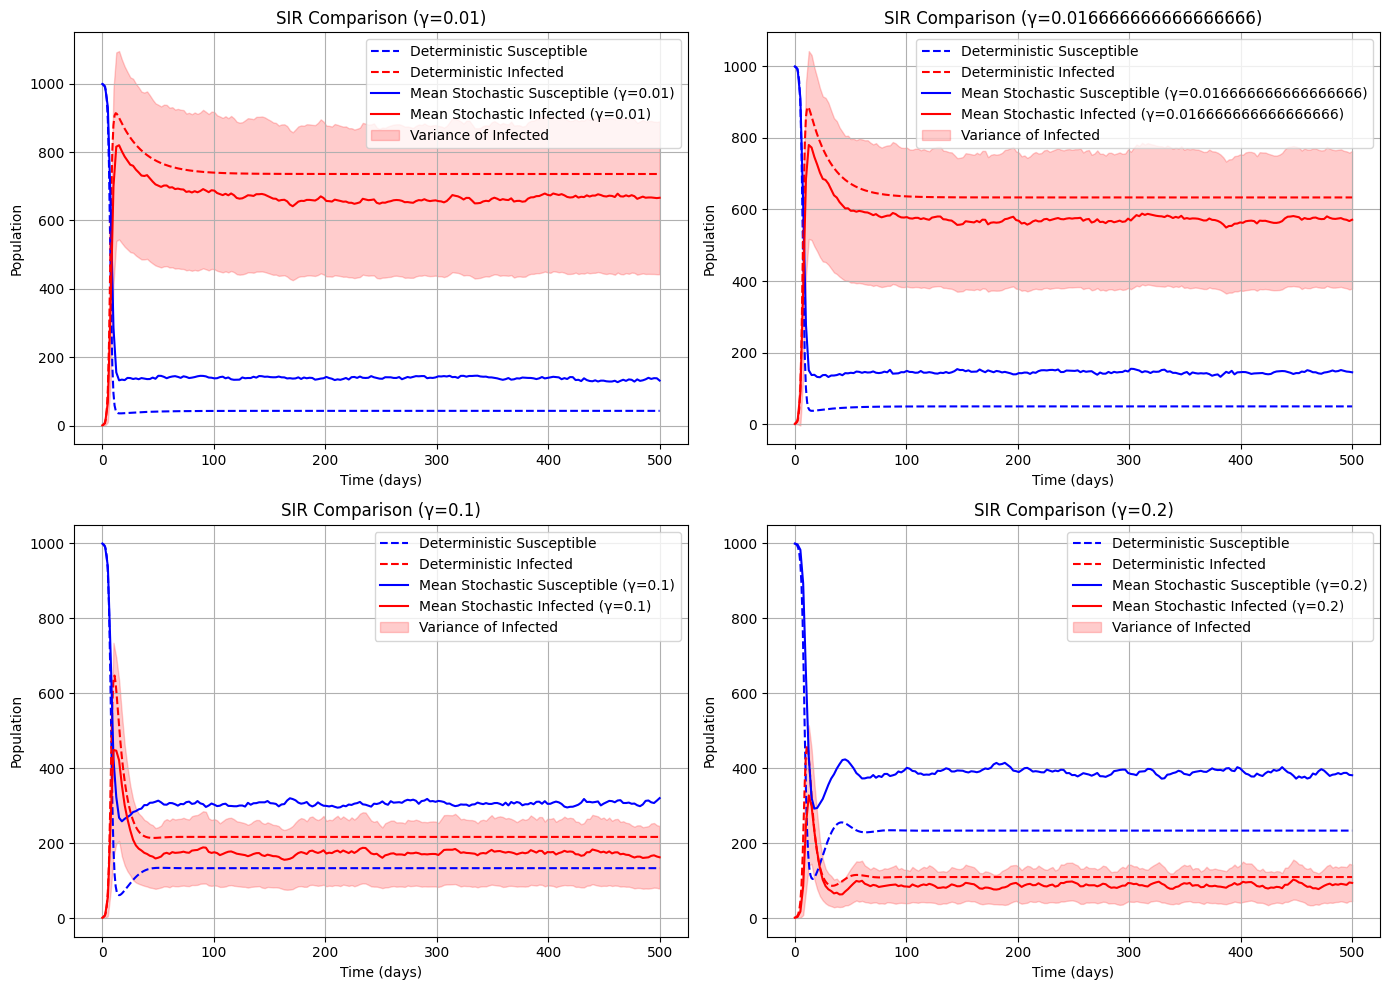

In [69]:
N = 1000  # Population size
beta = 1.0  # Constant value for beta
gamma_values = [0.01, 1/60, 0.1, 0.2]  # Different values for gamma
mu = 1 / 30
start_t = 0
end_t = 500
points_t = 500
sims = 10
tend = 500

# Prepare subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, gamma in enumerate(gamma_values):
    X0 = N - 1
    Y0 = 1
    Z0 = 0

    # Run deterministic solution
    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

    # Run stochastic simulation
    time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)

    # Top row: Mean plots with shaded variance for infected
    axs[i // 2, i % 2].plot(time, Xd, 'b--', label="Deterministic Susceptible")
    axs[i // 2, i % 2].plot(time, Yd, 'r--', label="Deterministic Infected")
    axs[i // 2, i % 2].plot(time_p, mean_Xs, 'b', label=f"Mean Stochastic Susceptible (γ={gamma})")
    axs[i // 2, i % 2].plot(time_p, mean_Ys, 'r', label=f"Mean Stochastic Infected (γ={gamma})")
    
    # Shaded region for variance of infected
    axs[i // 2, i % 2].fill_between(time_p, 
                                     mean_Ys - np.sqrt(var_Ys), 
                                     mean_Ys + np.sqrt(var_Ys), 
                                     color='red', alpha=0.2, label='Variance of Infected')
    
    axs[i // 2, i % 2].set_title(f"SIR Comparison (γ={gamma})")
    axs[i // 2, i % 2].set_xlabel("Time (days)")
    axs[i // 2, i % 2].set_ylabel("Population")
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].grid()

# Adjust layout
plt.tight_layout()
plt.show()


# Extinction event (different R0, fixed population size N)

In [87]:
sims_ext = 10

X0 = 999
Y0 = 1
Z0 = 0

N = 1000 

# R0 = beta / (gamma + mu)

beta_ext = np.linspace(0, 15, sims_ext)
gamma_ext = np.linspace(0.01, 10, sims_ext)
mu_ext = np.linspace(0.01, 3, sims_ext)

R0_ext = beta_ext / (gamma_ext + mu_ext)

Yd_ext = []
Ys_ext = []
extinction_stoch = []  # To track whether extinction happened in stochastic runs
extinction_deter = []  # To track extinction in deterministic runs

for i in range(sims_ext):
    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta_ext[i], gamma_ext[i], mu_ext[i], start_t = 0, end_t = 200, points_t = 200)
    Yd_ext.append(Yd[-1])
    extinction_deter.append(1 if Yd[-1] == 0 else 0)

    Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta_ext[i], gamma_ext[i], mu_ext[i], N, tend = 200, seed = i)
    Ys_ext.append(Ys[-1])
    extinction_stoch.append(1 if Ys[-1] == 0 else 0)

print("Stochastic extinctions:", np.sum(extinction_stoch), "out of " f"{sims_ext}" " simulations.")
print("Deterministic extinctions:", np.sum(extinction_deter),"out of " f"{sims_ext}" " simulations.")



Stochastic extinctions: 10 out of 10 simulations.
Deterministic extinctions: 0 out of 10 simulations.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_simulation_and_plot(param_diff, param_name, sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0):
    """
    General function to run simulations and plot extinction statistics.
    
    Args:
    - param_diff: Array of different values of N or R0.
    - param_name: Name of the parameter being varied ("N" or "R0").
    - sims_ext: Number of simulations to run for each parameter value.
    - beta_ext, gamma_ext, mu_ext: Arrays of transmission, recovery, and death rates.
    - t_end: End time for the simulation.
    - X0, Y0, Z0: Initial conditions (susceptible, infected, recovered).
    
    Returns:
    - Sorted parameter values and corresponding extinction data (for further plotting).
    """
    # Initialize lists to store results
    Ys_ext2 = []  # Average extinction times
    extinction_counts = []  # Number of extinctions for each parameter value

    # Loop over different values of the parameter (N or R0)
    for i, param in enumerate(param_diff):
        Ys_sim = []  # Temporary list to store extinction times for each simulation
        ext_count = 0  # Counter for the number of extinctions
        
        for sim in range(sims_ext):
            # Adjust X0 if simulating for different N values
            if param_name == "N":
                X0 = int(param) - 1  # Susceptible individuals (N-1)
            else:
                X0 = X0  # Keep it fixed for R0

            # Run the simulation using gillespie_sir for current beta, gamma, mu
            Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta_ext[i], gamma_ext[i], mu_ext[i], X0 + Y0 + Z0, tend=t_end, seed=sim)

            # Find the index of the first 0 in the Ys (extinction time)
            if 0 in Ys:
                extinction_time = Ys.index(0)
                Ys_sim.append(extinction_time)  # Only append if extinction happens
                ext_count += 1  # Increment extinction count if extinction occurs
            else:
                # If no extinction occurs, do nothing
                pass

        # Calculate the average extinction time only if there were extinctions
        if Ys_sim:
            average_extinction_time = sum(Ys_sim) / len(Ys_sim)
            Ys_ext2.append(average_extinction_time)
        else:
            Ys_ext2.append(np.nan)  # If no extinctions, append NaN

        extinction_counts.append(ext_count)  # Store the number of extinctions for this parameter
        print(f'For {param_name} = {param}, total extinctions = {ext_count}, average extinction time = {Ys_ext2[-1]}')

    # Sort the parameter values and corresponding data
    sorted_indices = np.argsort(param_diff)
    param_diff_sorted = np.array(param_diff)[sorted_indices]
    Ys_ext2_sorted = np.array(Ys_ext2)[sorted_indices]
    extinction_counts_sorted = np.array(extinction_counts)[sorted_indices]

    return param_diff_sorted, Ys_ext2_sorted, extinction_counts_sorted


# Example parameters
sims_ext = 30  # Number of simulations per parameter
beta_ext = np.logspace(-1, 1.5, sims_ext)  # Transmission rates in the range [0.1, 31.6]
gamma_ext = np.linspace(0.01, 1, sims_ext)  # Recovery rates in the range [0.01, 1]
mu_ext = np.linspace(0.01, 0.5, sims_ext)  # Death rates in the range [0.01, 0.5]
t_end = 200  # Simulation end time

# N and R0 values
N_diff = np.linspace(500, 10000, 10)  # Population sizes for which we will run simulations
R0_diff = beta_ext / (gamma_ext + mu_ext)  # Calculate R0 values
X0 = 999  # Initial number of susceptible individuals
Y0 = 1  # Initial number of infected individuals
Z0 = 0  # Initial number of recovered individuals

# Run the simulations for N and R0
N_sorted, Ys_ext2_N_sorted, extinction_counts_N_sorted = run_simulation_and_plot(N_diff, "N", sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0)
R0_sorted, Ys_ext2_R0_sorted, extinction_counts_R0_sorted = run_simulation_and_plot(R0_diff, "R0", sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0)

# Create 2x2 subplot for all four plots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Average extinction time vs N
ax[0, 0].plot(N_sorted, Ys_ext2_N_sorted, marker='o', color='blue', label='Avg Extinction Time (N)')
ax[0, 0].set_title("Average Extinction Time vs Population Size (N)")
ax[0, 0].set_xlabel("Population size N")
ax[0, 0].set_ylabel("Average Time to Extinction")
ax[0, 0].grid(True)
ax[0, 0].legend()

# Plot 2: Total number of extinctions vs N
ax[0, 1].plot(N_sorted, extinction_counts_N_sorted, marker='o', color='green', label='Number of Extinctions (N)')
ax[0, 1].set_title("Total Number of Extinctions vs Population Size (N)")
ax[0, 1].set_xlabel("Population size N")
ax[0, 1].set_ylabel("Total Number of Extinctions")
ax[0, 1].grid(True)
ax[0, 1].legend()

# Plot 3: Average extinction time vs R0
ax[1, 0].plot(R0_sorted, Ys_ext2_R0_sorted, marker='o', color='blue', label='Avg Extinction Time (R0)')
ax[1, 0].set_title("Average Extinction Time vs R0")
ax[1, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 0].set_ylabel("Average Time to Extinction")
ax[1, 0].grid(True)
ax[1, 0].legend()

# Plot 4: Total number of extinctions vs R0
ax[1, 1].plot(R0_sorted, extinction_counts_R0_sorted, marker='o', color='green', label='Number of Extinctions (R0)')
ax[1, 1].set_title("Total Number of Extinctions vs R0")
ax[1, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 1].set_ylabel("Total Number of Extinctions")
ax[1, 1].grid(True)
ax[1, 1].legend()

plt.tight_layout()
plt.show()
